# Robot-dance model with optimal vaccination

This notebook includes vaccination in the robot-dance model and find the best strategyy considering some constraints.

In [1]:
import numpy as np
import gekko as gk
import pickle

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

from scipy.integrate import solve_ivp

import scienceplots
plt.style.use(['science','ieee'])

Consider the problem 

\begin{split}
    \min_{u \in L_1([0,T])} &c_v V(T) + c_h H(T) \\[0.5px]
    \text{s.a. } &V(t) \le D(t), \text{ a.e. } t \in [0,T] \\[0.5px] 
    &u_i(t)\cdot S_i(t) \le v_i^{\max}, \text{ a.e. } t \in [0,T] \\[0.5px]
    &u_i(t) \ge 0, i = 1,\dots,K, \text{ a.e. } t \in [0,T] \\[0.5px] 
    &\frac{dS_i}{dt} = -\alpha \beta_i S_i I_i - (1-\alpha) S_i \sum_{j=1}^K \beta_j p_{ij} I_j^{\mathrm{eff}} - u_i S_i \\
    &\frac{dI_i}{dt} = \alpha \beta_i S_i I_i + (1-\alpha) S_i \sum_{j=1}^K \beta_j p_{ij} I_j^{\mathrm{eff}} - \gamma I_i \\
    &\frac{dV}{dt} = \sum_{i=1}^K n_i u_i \cdot S_i \\
    &\frac{dH}{dt} = \sum_{i=1}^K n_i I_i \\
    &S_i(0) = s_{i0}, I_i(0) = i_{i0}, V(0) = 0.
\end{split}

In [3]:
def model_ode(t, y, u, alpha, beta, gamma, mu, K, p_matrix, population, population_eff):
    """
    Defines a system of ordinary differential equations (ODEs) for a compartmental model in epidemiology.

    Parameters:
    t (float): The current time.
    y (array-like): The current state of the system. Should be a 1D array of length 4*K, 
                    where the first K elements represent the susceptible individuals, 
                    the next K elements represent the exposed individuals, 
                    the next K elements represent the infectious individuals, 
                    and the last K elements represent the recovered individuals.
    u (array-like): The vaccinatio rate for each city.
                    Should be a 1D array of length K.
    alpha (float): Proportion of the night among the 24 hours.
    beta (array-like): The transmission rate for each city. 
                       Should be a 1D array of length K.
    gamma (float): The recovery rate (the inverse of the infectious period).
    mu (float): The birth and natural death rate. 
    K (int): The number of cities or groups in the population.
    p_matrix (array-like): A matrix that represents the transitions between different cities. 
                           Should be a 2D array of shape (K, K).
    population (array-like): The total population in each city. 
                             Should be a 1D array of length K.
    population_eff (array-like): The effective population during the day.
                                 Should be a 1D array of length K.
                                 P_i^{eff} = sum_{j=1}^K p_matrix{ji} population_j
                                 
    Returns:
    array-like: The rates of change of the susceptible, exposed, infectious, and recovered individuals. 
                Returns a 1D array of length 4*K.
    """
    S, I, R, _ = y[:K], y[K:2*K], y[2*K:3*K], y[3*K:]
    I_eff = (I * population) @ p_matrix / population_eff
    S_dot = -alpha * beta * S * I - (1-alpha) * S * (p_matrix @ (beta * I_eff))
    I_dot = -S_dot - (gamma + mu) * I
    R_dot = u * S + gamma * I - mu * R
    H_dot = -S_dot
    S_dot += mu - (u + mu) * S
    
    return np.hstack([S_dot, I_dot, R_dot, H_dot])

Now the optimal control program.

In [4]:
def optimal_vaccination_strategy(parameters):
    
    # Gekko object
    remote=True
    if 'remote' in parameters:
        remote = parameters['remote']
    m = gk.GEKKO(remote=remote)
    
    # Including the time
    T = parameters['T']
    npd = 20
    if 'npd' in parameters:
        npd = parameters['npd']
    n_points = npd*T + 1
    m.time = np.linspace(0, T, n_points)

    # Number of cities
    populations = parameters['populations']
    K = len(populations)

    # Parameters
    beta = parameters['beta']
    cv = m.Const(parameters['cv'])
    ch = m.Const(parameters['ch'])
    alpha = m.Const(parameters['alpha'])
    gamma = m.Const(parameters['gamma'])
    mu = m.Const(parameters['mu'])
    p_matrix = parameters['p_matrix']
    population_eff = populations @ p_matrix

    # Initial values
    s0 = parameters['s0']
    i0 = parameters['i0']
    
    # Constraints
    week_max = parameters['week_max']
    rate_max = parameters['rate_max']

    # Including the variables
    s = m.Array(m.Var, K, lb=0.0)
    i = m.Array(m.Var, K, lb=0.0)  
    v = m.Var(value=0.0, lb=0.0)
    h = m.Var(value=0.0, lb=0.0)
    
    w = [m.MV(lb=0.0, ub=rate_max[city], name='u{}'.format(city)) for city in range(K)]
    for city in range(K):
        s[city].value = s0[city]
        i[city].value = i0[city]        
        w[city].STATUS = 1
        w[city].DCOST = 0

    # Maximizing 
    obj_points = np.zeros(n_points)
    obj_points[-1] = 1.0
    final = m.Param(value=obj_points)
    m.Obj((cv * v + ch * h) * final)

    # ODE equations
    i_eff = [m.Intermediate(sum(p_matrix[:,city]*populations*i)/population_eff[city]) for city in range(K)]
    for city in range(K):
        new_infections = s[city] * (alpha*beta[city]*i[city] + (1-alpha)*sum(beta*p_matrix[city,:]*i_eff))
        m.Equation(s[city].dt() == -new_infections - w[city] + mu - mu*s[city])
        m.Equation(i[city].dt() == new_infections - (gamma + mu)*i[city])
    m.Equation(v.dt() == sum(w*populations))
    m.Equation(h.dt() == sum(i*populations))

    for week in range(T//7):
        weekly_mark = np.zeros(n_points)
        weekly_mark[npd*7*(week+1)] = 1.0
        weekly_constraint = m.Param(value=weekly_mark)
        m.Equation( v * weekly_constraint <= week_max[week])

    # Solving
    m.options.IMODE = 6
    m.options.NODES = 3
    m.options.MV_TYPE = 1
    m.options.SOLVER = 3  # Using IPOPT solver
    m.options.MAX_ITER = 200
    m.options.DIAGLEVEL = 1
    
    m.options.RTOL=parameters['RTOL']
    m.options.OTOL=parameters['OTOL']

    m.solve(disp=True)

    # Adjoint variables calculation
    s = np.array([list(s[city]) for city in range(K)])
    i = np.array([list(i[city]) for city in range(K)])
    w = np.array([list(w[city]) for city in range(K)])
    psi_s = np.zeros_like(s)
    psi_i = np.zeros_like(i)
    delta_t = 1/npd
    B = np.diag(beta)
    A = alpha.value * B + (1-alpha.value) * p_matrix @ B @ np.diag(1/population_eff) @ p_matrix.T @ np.diag(populations)    
    for index in range(n_points-1, 0, -1):
        derivative = (psi_s[:, index] - psi_i[:, index]) * (A @ i[:, index]) + mu.value * psi_s[:, index]
        psi_s[:, index-1] = psi_s[:, index] - delta_t*derivative
        
        derivative = A.T @ np.diag(s[:, index]) @ (psi_s[:, index] - psi_i[:, index]) 
        derivative += psi_i[:, index]*(gamma.value + mu.value) + ch.value * populations
        psi_i[:, index-1] = psi_i[:, index] - delta_t*derivative
        
    return m, s, i, np.array(v), np.array(h), w, psi_s, psi_i

## Multi-city interaction

In [11]:
# number of cities
K = 3

# Fixed parameters
gamma = 1/7
mu = 0.0
beta = np.array([0.3, 0.2, 0.1])
alpha = 0.64

# Population settings
populations = 1e5*np.array([100, 10, 10])
p_matrix = np.array([[1/3,1/3,1/3],[1/3,1/3,1/3],[1/3,1/3,1/3]])
p_matrix = np.array([[0.9,0.05,0.05],[1/2-0.05,1/2-0.05,0.1],[1/2-0.05,0.1,1/2-0.05]])
population_eff = populations @ p_matrix

T = 28

rate_max = np.array([0.3, 0.3, 0.3])/T
week_max = np.array([1, 2, 3, 4])/30

In [12]:
%%time
populations = populations/populations.sum()
population_eff = populations @ p_matrix
parameters = {'T': T, 'populations': populations, 'p_matrix': p_matrix,
              'beta': beta, 'alpha': alpha, 'gamma': gamma, 'mu': mu,
              'npd': 15, 'remote': True,
              's0': np.array([0.96, 0.95, 0.97]), 
              'i0': np.array([0.02, 0.02, 0.01]), 
              'cv': 0.01, 'ch': 100,
              'week_max': week_max,
              'rate_max': rate_max,
              'RTOL': 1e-6, 'OTOL': 1e-6}

m, susceptible, infected, vaccinated, hospitalized, w, psi_s, psi_i  = optimal_vaccination_strategy(parameters)

apm 62.49.130.185_gk_model1 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 Called files(          55 )
 files: overrides.dbs does not exist
 
 Run id   : 2025y03m15d09h42m42.532s
 
 COMMAND LINE ARGUMENTS
 coldstart:            0
 imode    :            6
 dbs_read :  T
 dbs_write:  T
 specs    :  T
 
 ctl selected
 Called files(          35 )
 READ info FILE FOR VARIABLE DEFINITION: 62.49.130.185_gk_model1.info
 initialization step:            0
 Parsing model file 62.49.130.185_gk_model1.apm
 Read model file (sec):  8.099999999103602E-003
 Initialize constants (sec):  6.999999986874172E-004
 Determine model size (sec):  4.300000000512227E-003
 Allocate memory (sec):  9.999999929277692E-005
 Parse and store model (sec):  3.099999999903957E-003
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :          

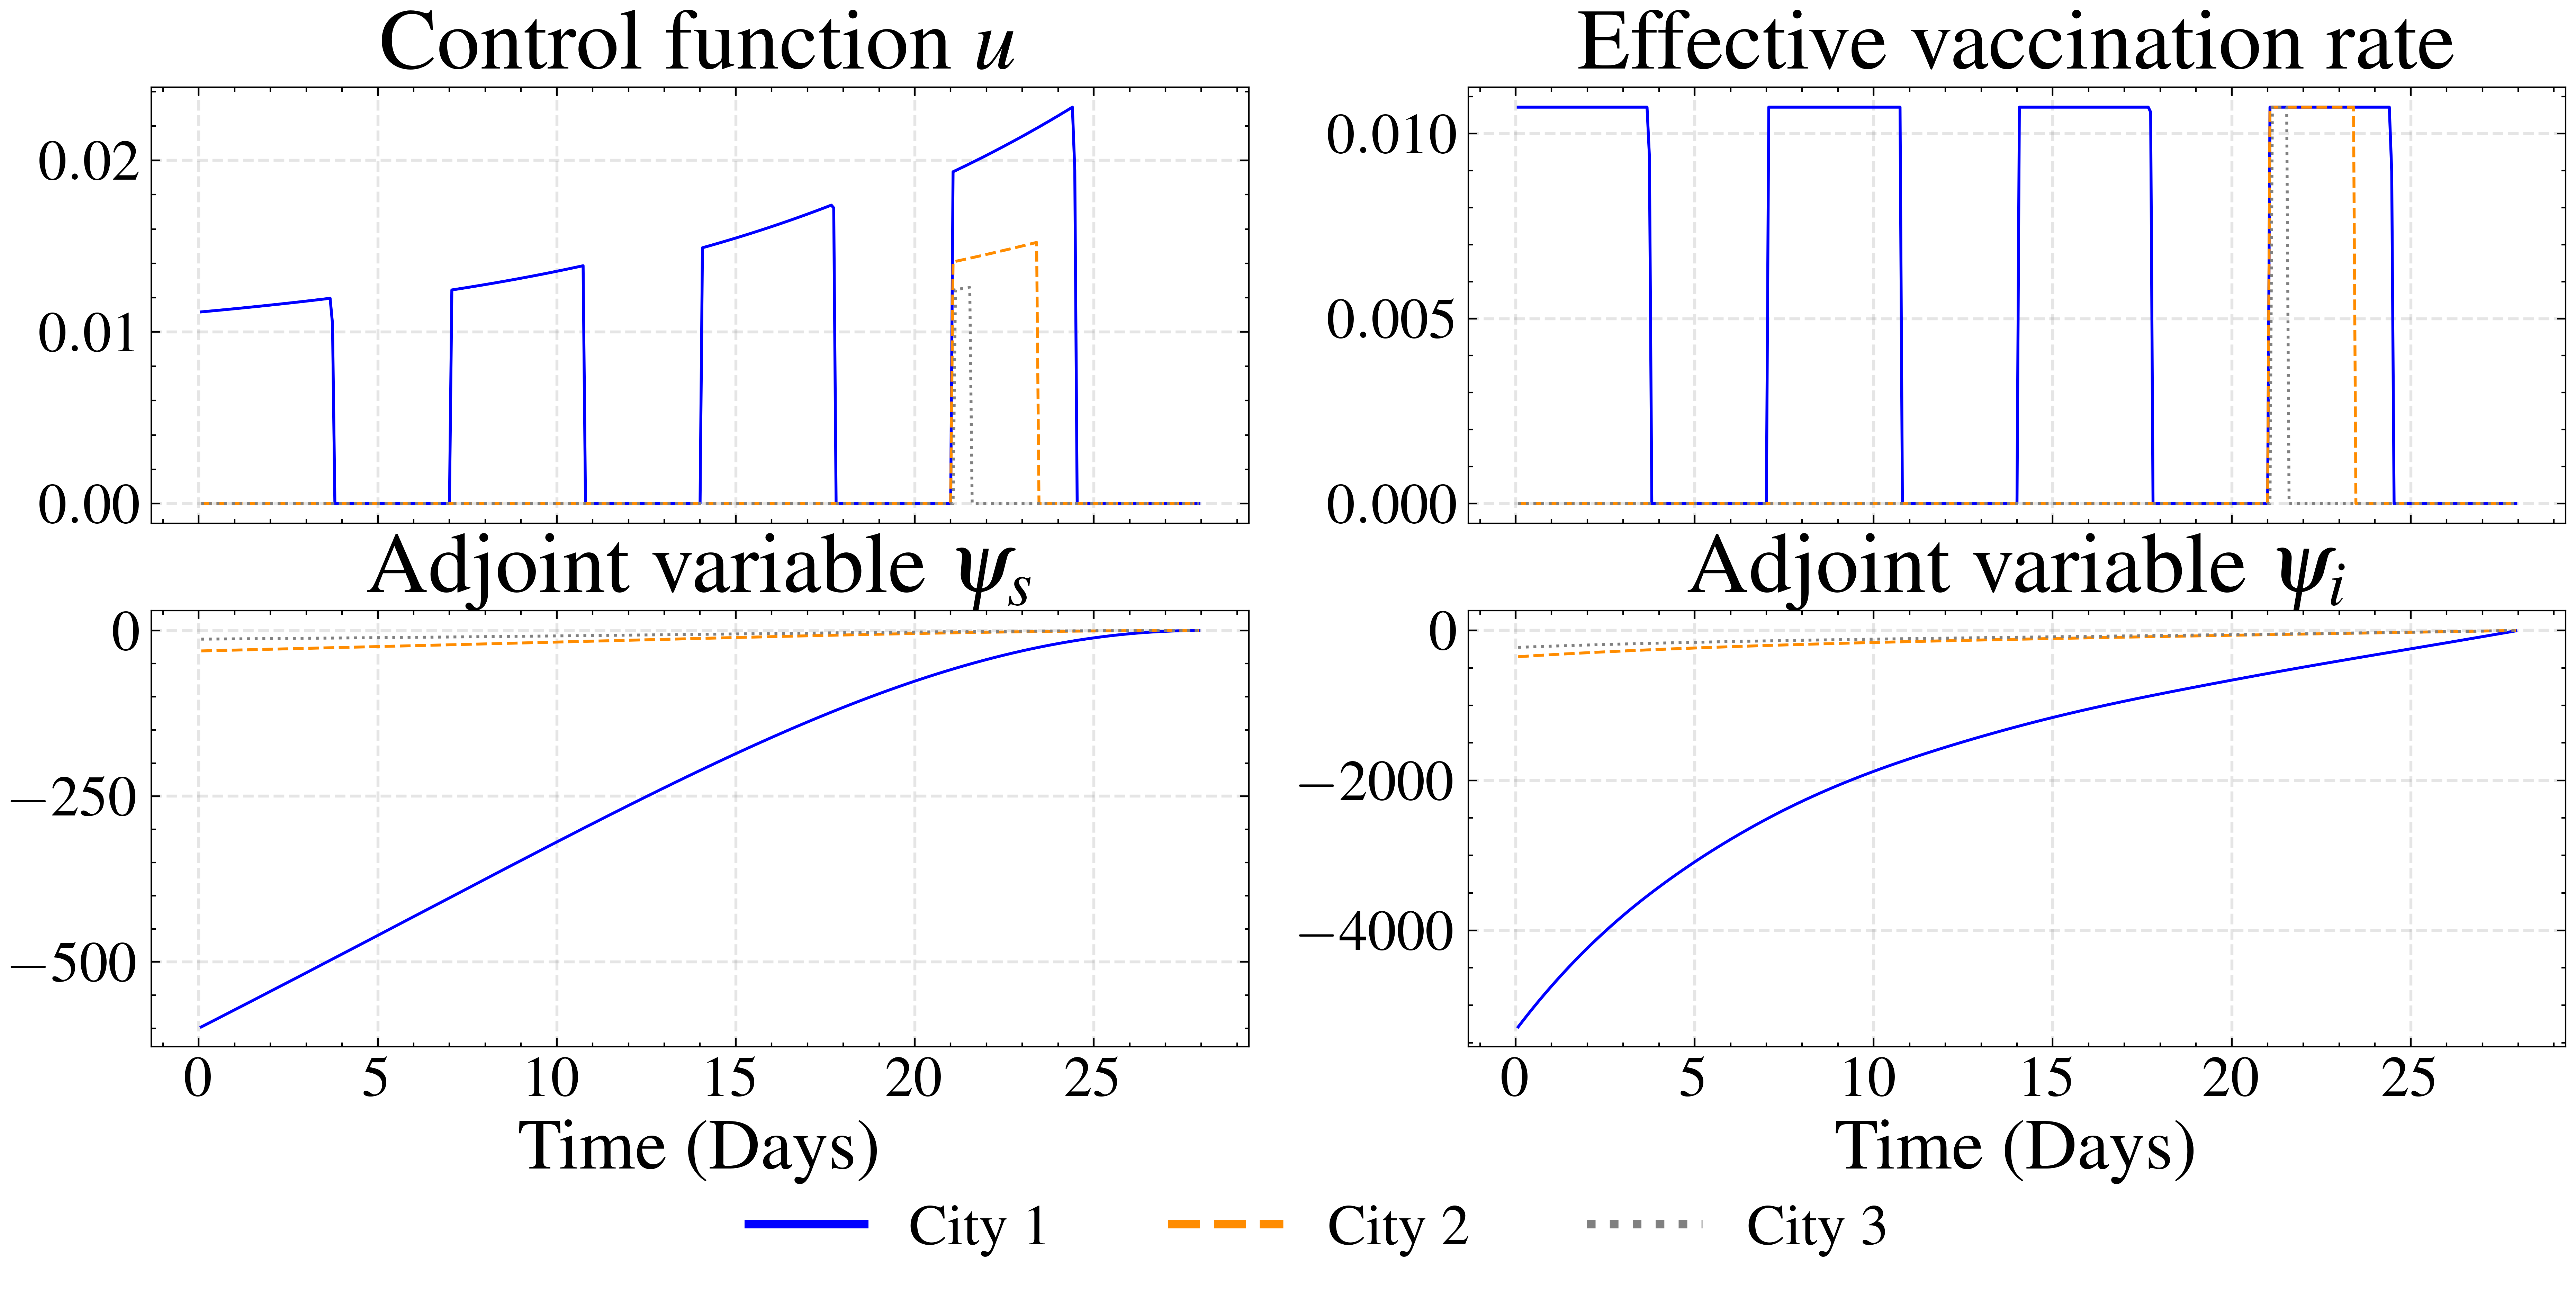

In [19]:
fig, ax = plt.subplots(2,2, figsize=(15,6), sharex=True)

colors = ['blue', 'darkorange', 'gray']
linestyles = ['-', '--', ':']
labels = ['City 1', 'City 2', 'City 3']

for city in range(len(populations)):
    
    #ax[0,0].plot(m.time[1:-1], susceptible[city][1:-1], label=labels[city], c=colors[city], ls=linestyles[city])
    #ax[0,1].plot(m.time[1:-1], infected[city][1:-1], label=labels[city], c=colors[city], ls=linestyles[city])
    
    u = w[city]/susceptible[city]
    ax[0,0].plot(m.time[1:-1], u[1:-1], label=labels[city], c=colors[city], ls=linestyles[city])
    ax[0,1].plot(m.time[1:-1], w[city][1:-1], label=labels[city], color=colors[city], ls=linestyles[city])

    ax[1,0].plot(m.time[1:-1], psi_s[city][1:-1], label=labels[city], c=colors[city], ls=linestyles[city])
    ax[1,1].plot(m.time[1:-1], psi_i[city][1:-1], label=labels[city], c=colors[city], ls=linestyles[city])
    
for i in range(2):
    for j in range(2):
        ax[i,j].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
    
    
#ax[0,0].set_title('Susceptible individuals', fontsize=30)
#ax[0,1].set_title('Infectious individuals', fontsize=30)
ax[0,0].set_title(r'Control function $u$', fontsize=30)
ax[0,1].set_title('Effective vaccination rate', fontsize=30)
ax[1,0].set_title(r'Adjoint variable $\psi_s$', fontsize=30)
ax[1,1].set_title(r'Adjoint variable $\psi_i$', fontsize=30)

ax[1,0].set_xlabel('Time (Days)', fontsize=25)
ax[1,1].set_xlabel('Time (Days)', fontsize=25)

lines = [Line2D([0], [0], color=c, linewidth=3, linestyle=ls) for c, ls in zip(colors, linestyles)]
fig.legend(lines, labels, loc='lower center', fontsize=20, ncol=5, bbox_to_anchor=(0.5,-0.1))

ax[0,0].tick_params(axis='y', labelsize=20)
ax[1,0].tick_params(axis='y', labelsize=20)
#ax[2,0].tick_params(axis='y', labelsize=20)
ax[0,1].tick_params(axis='y', labelsize=20)
ax[1,1].tick_params(axis='y', labelsize=20)
#ax[2,1].tick_params(axis='y', labelsize=20)

ax[1,0].tick_params(axis='x', labelsize=20)
ax[1,1].tick_params(axis='x', labelsize=20)

plt.savefig('../images_paper/figure1.pdf', bbox_inches='tight')

plt.show()

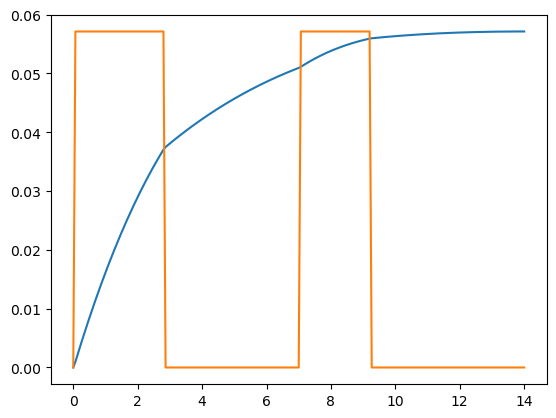

In [7]:
result = psi_s*susceptible - (parameters['cv'])*populations[:, np.newaxis]*susceptible  #= mu*populations*susceptible + - ri*susceptible - rik
plt.plot(m.time, rate_max[0]*(result[0] - np.min(result[0]))/(np.max(result[0]) - np.min(result[0])))
plt.plot(m.time, w[0])

In [8]:
I_eff = np.array([(populations * infected[:, col]) @ p_matrix / population_eff for col in range(infected.shape[1])]).T
S_dot = -alpha * beta[:, np.newaxis] * susceptible * infected - (1-alpha) * susceptible * (p_matrix @ (beta[:, np.newaxis] * I_eff))
I_dot = -S_dot - (gamma + mu) * infected
V_dot = np.sum(populations[:, np.newaxis] * w, axis=0)
H_dot = np.sum(populations[:, np.newaxis] * infected, axis=0)
S_dot += mu - mu * susceptible - w

reduced_hamiltonian = (psi_s * S_dot + psi_i * I_dot).sum(axis=0) - parameters['cv'] * V_dot - parameters['ch'] * H_dot
mu_function = np.divide(-reduced_hamiltonian, V_dot, where=V_dot!=0, out=np.full_like(reduced_hamiltonian, np.nan))

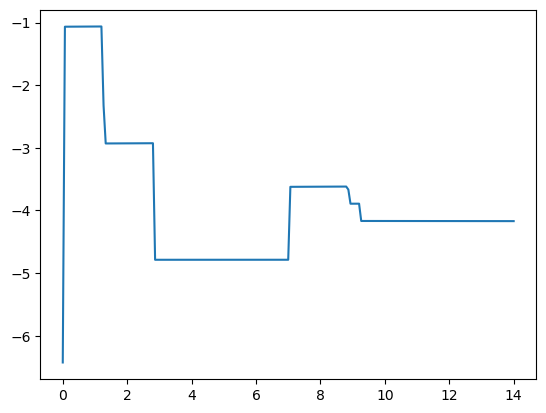

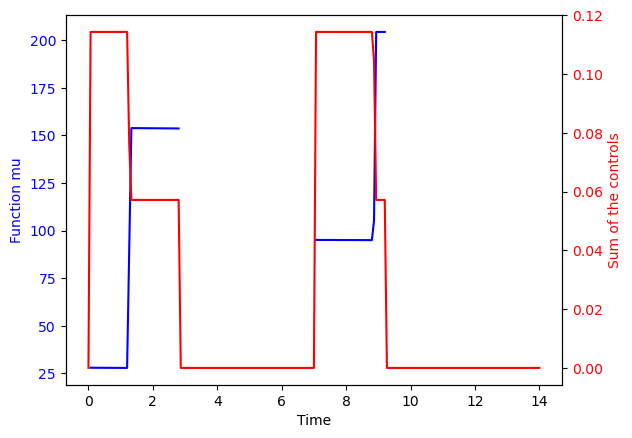

In [9]:
plt.plot(m.time, reduced_hamiltonian)
plt.show()


fig, ax1 = plt.subplots()
ax1.plot(m.time, mu_function, 'b-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Function mu', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(m.time, w.sum(axis=0), 'r-')
ax2.set_ylabel('Sum of the controls', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.show()

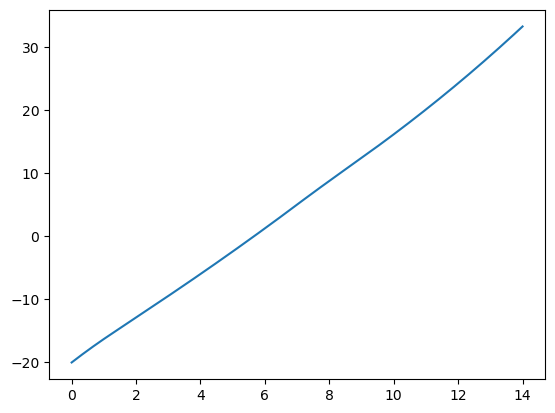

In [11]:
plt.plot(m.time, gamma*psi_i[1] + parameters['ch']*populations[1])

## Paper figures

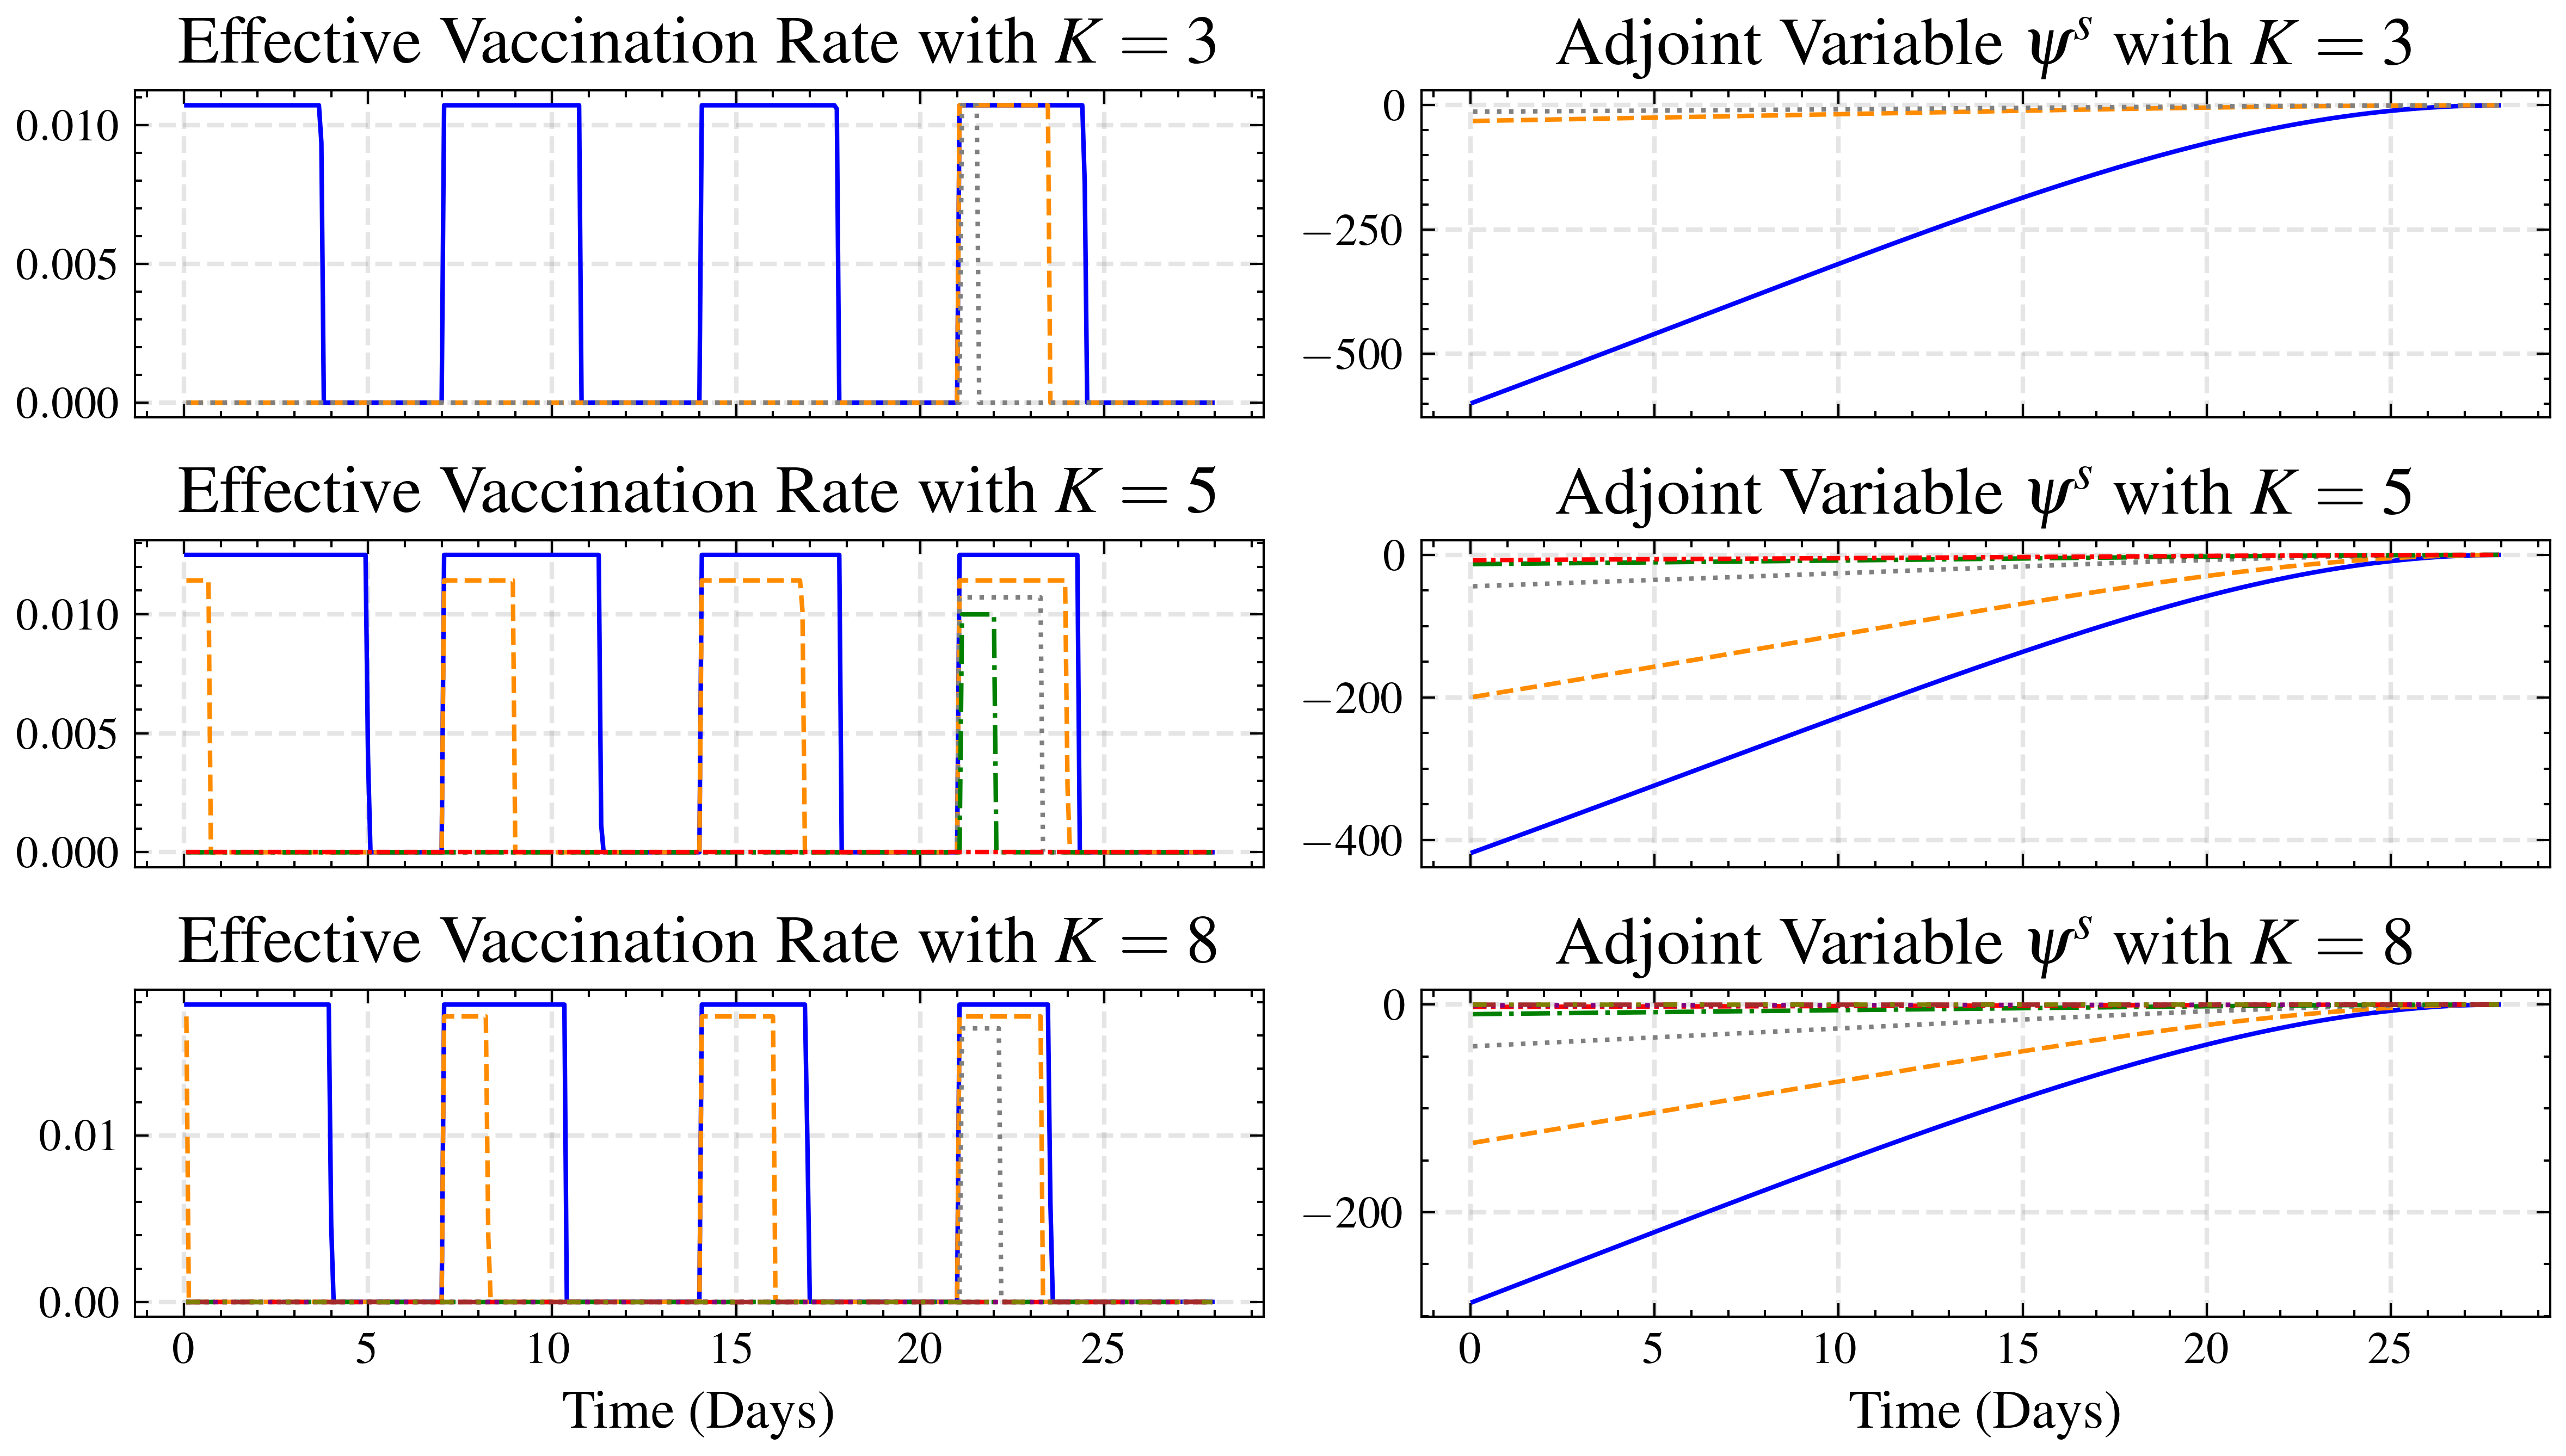

In [20]:
T = 28
gamma = 1/7
alpha = 0.64
mu = 0.0
week_max = np.array([1, 2, 3, 4]) / 30

# --- Experiment 1: 3 cities ---
K1 = 3
beta1 = np.array([0.3, 0.2, 0.1])  # all <= 0.4
populations1 = 1e5 * np.array([100, 10, 10])
populations1 = populations1 / populations1.sum()
p_matrix1 = np.array([[0.9,   0.05, 0.05],
                      [0.45,  0.45, 0.10],
                      [0.45,  0.10, 0.45]])
rate_max1 = np.full(K1, 0.3) / T
s0_1 = np.array([0.96, 0.97, 0.95])
i0_1 = np.array([0.02, 0.02, 0.01])
params1 = {'T': T,
           'populations': populations1,
           'p_matrix': p_matrix1,
           'beta': beta1,
           'alpha': alpha,
           'gamma': gamma,
           'mu': mu,
           'npd': 15,
           'remote': True,
           's0': s0_1,
           'i0': i0_1,
           'cv': 0.01,
           'ch': 100,
           'week_max': week_max,
           'rate_max': rate_max1,
           'RTOL': 1e-6,
           'OTOL': 1e-6}

# --- Experiment 2: 5 cities ---
K2 = 5
beta2 = np.array([0.35, 0.3, 0.25, 0.2, 0.15])
populations2 = 1e5 * np.array([50, 30, 10, 5, 5])
populations2 = populations2 / populations2.sum()
p_matrix2 = np.array([
    [0.8,  0.05, 0.05, 0.05, 0.05],
    [0.1,  0.7,  0.1,  0.05, 0.05],
    [0.05, 0.1,  0.7,  0.1,  0.05],
    [0.05, 0.05, 0.1,  0.7,  0.1],
    [0.05, 0.05, 0.05, 0.1,  0.75]
])
rate_max2 = np.array([0.35, 0.32, 0.3, 0.28, 0.26]) / T
s0_2 = np.full(K2, 0.97)  # > 0.95 for all cities
i0_2 = np.full(K2, 0.01)
params2 = {'T': T,
           'populations': populations2,
           'p_matrix': p_matrix2,
           'beta': beta2,
           'alpha': alpha,
           'gamma': gamma,
           'mu': mu,
           'npd': 15,
           'remote': True,
           's0': s0_2,
           'i0': i0_2,
           'cv': 0.01,
           'ch': 100,
           'week_max': week_max,
           'rate_max': rate_max2,
           'RTOL': 1e-6,
           'OTOL': 1e-6}

# --- Experiment 3: 8 cities ---
K3 = 8
beta3 = np.array([0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.04])
populations3 = 1e5 * np.array([70, 40, 20, 10, 5, 3, 1, 1])
populations3 = populations3 / populations3.sum()
p_matrix3 = np.array([
    [0.7,  0.1,  0.05, 0.05, 0.03, 0.03, 0.02, 0.02],
    [0.1,  0.7,  0.1,  0.02, 0.02, 0.02, 0.02, 0.02],
    [0.05, 0.1,  0.75, 0.02, 0.02, 0.02, 0.02, 0.02],
    [0.05, 0.02, 0.02, 0.75, 0.05, 0.05, 0.03, 0.03],
    [0.03, 0.02, 0.02, 0.05, 0.8,  0.03, 0.02, 0.03],
    [0.03, 0.02, 0.02, 0.05, 0.03, 0.8,  0.03, 0.02],
    [0.02, 0.02, 0.02, 0.03, 0.02, 0.03, 0.85, 0.01],
    [0.02, 0.02, 0.02, 0.03, 0.03, 0.02, 0.01, 0.85]
])
rate_max3 = np.array([0.5, 0.48, 0.46, 0.44, 0.42, 0.4, 0.38, 0.36]) / T 
s0_3 = np.full(K3, 0.98)
i0_3 = np.full(K3, 0.005)
params3 = {'T': T,
           'populations': populations3,
           'p_matrix': p_matrix3,
           'beta': beta3,
           'alpha': alpha,
           'gamma': gamma,
           'mu': mu,
           'npd': 15,
           'remote': True,
           's0': s0_3,
           'i0': i0_3,
           'cv': 0.01,
           'ch': 100,
           'week_max': week_max,
           'rate_max': rate_max3,
           'RTOL': 1e-6,
           'OTOL': 1e-6}

experiments = [params1, params2, params3]

with open("simulation_results.pkl", "rb") as f:
    results = pickle.load(f)

fig, ax = plt.subplots(3, 2, figsize=(8, 5), sharex=True)
colors = ['blue', 'darkorange', 'gray', 'green', 'red', 'purple', 'brown', 'olive']
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1)), (0, (1, 1)), (0, (5, 5)), (0, (3, 5, 1, 5))]

for exp_idx, (params, (m, w, psi_s)) in enumerate(zip(experiments, results)):
    K = len(params['populations'])
    for city in range(K):
        # Column 1: effective vaccination rate w[city][1:-1]
        ax[exp_idx, 0].plot(m.time[1:-1], w[city][1:-1],
                            label=f'City {city+1}',
                            color=colors[city % len(colors)],
                            linestyle=linestyles[city % len(linestyles)])
        # Column 2: adjoint variable psi_s[city][1:-1]
        ax[exp_idx, 1].plot(m.time[1:-1], psi_s[city][1:-1],
                            label=f'City {city+1}',
                            color=colors[city % len(colors)],
                            linestyle=linestyles[city % len(linestyles)])
    ax[exp_idx, 0].set_title(r'Effective Vaccination Rate with $K={}$'.format(K), fontsize=15)
    ax[exp_idx, 1].set_title(f'Adjoint Variable $\psi^s$ with  $K={K}$', fontsize=15)
    ax[exp_idx, 0].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2)
    ax[exp_idx, 1].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2)
    if exp_idx == 2:
        ax[exp_idx, 0].set_xlabel('Time (Days)', fontsize=12)
        ax[exp_idx, 1].set_xlabel('Time (Days)', fontsize=12)
    ax[exp_idx, 0].tick_params(axis='both', labelsize=10)
    ax[exp_idx, 1].tick_params(axis='both', labelsize=10)

# Create a global legend (based on the maximum number of cities among experiments)
max_K = max(len(params['populations']) for params in experiments)
legend_lines = [plt.Line2D([0], [0], color=colors[i], linestyle=linestyles[i], linewidth=2)
                for i in range(max_K)]
legend_labels = [f'City {i+1}' for i in range(max_K)]
#fig.legend(legend_lines, legend_labels, loc='lower center', fontsize=12,
#           ncol=max_K, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../images_paper/figure1.pdf")
plt.show()

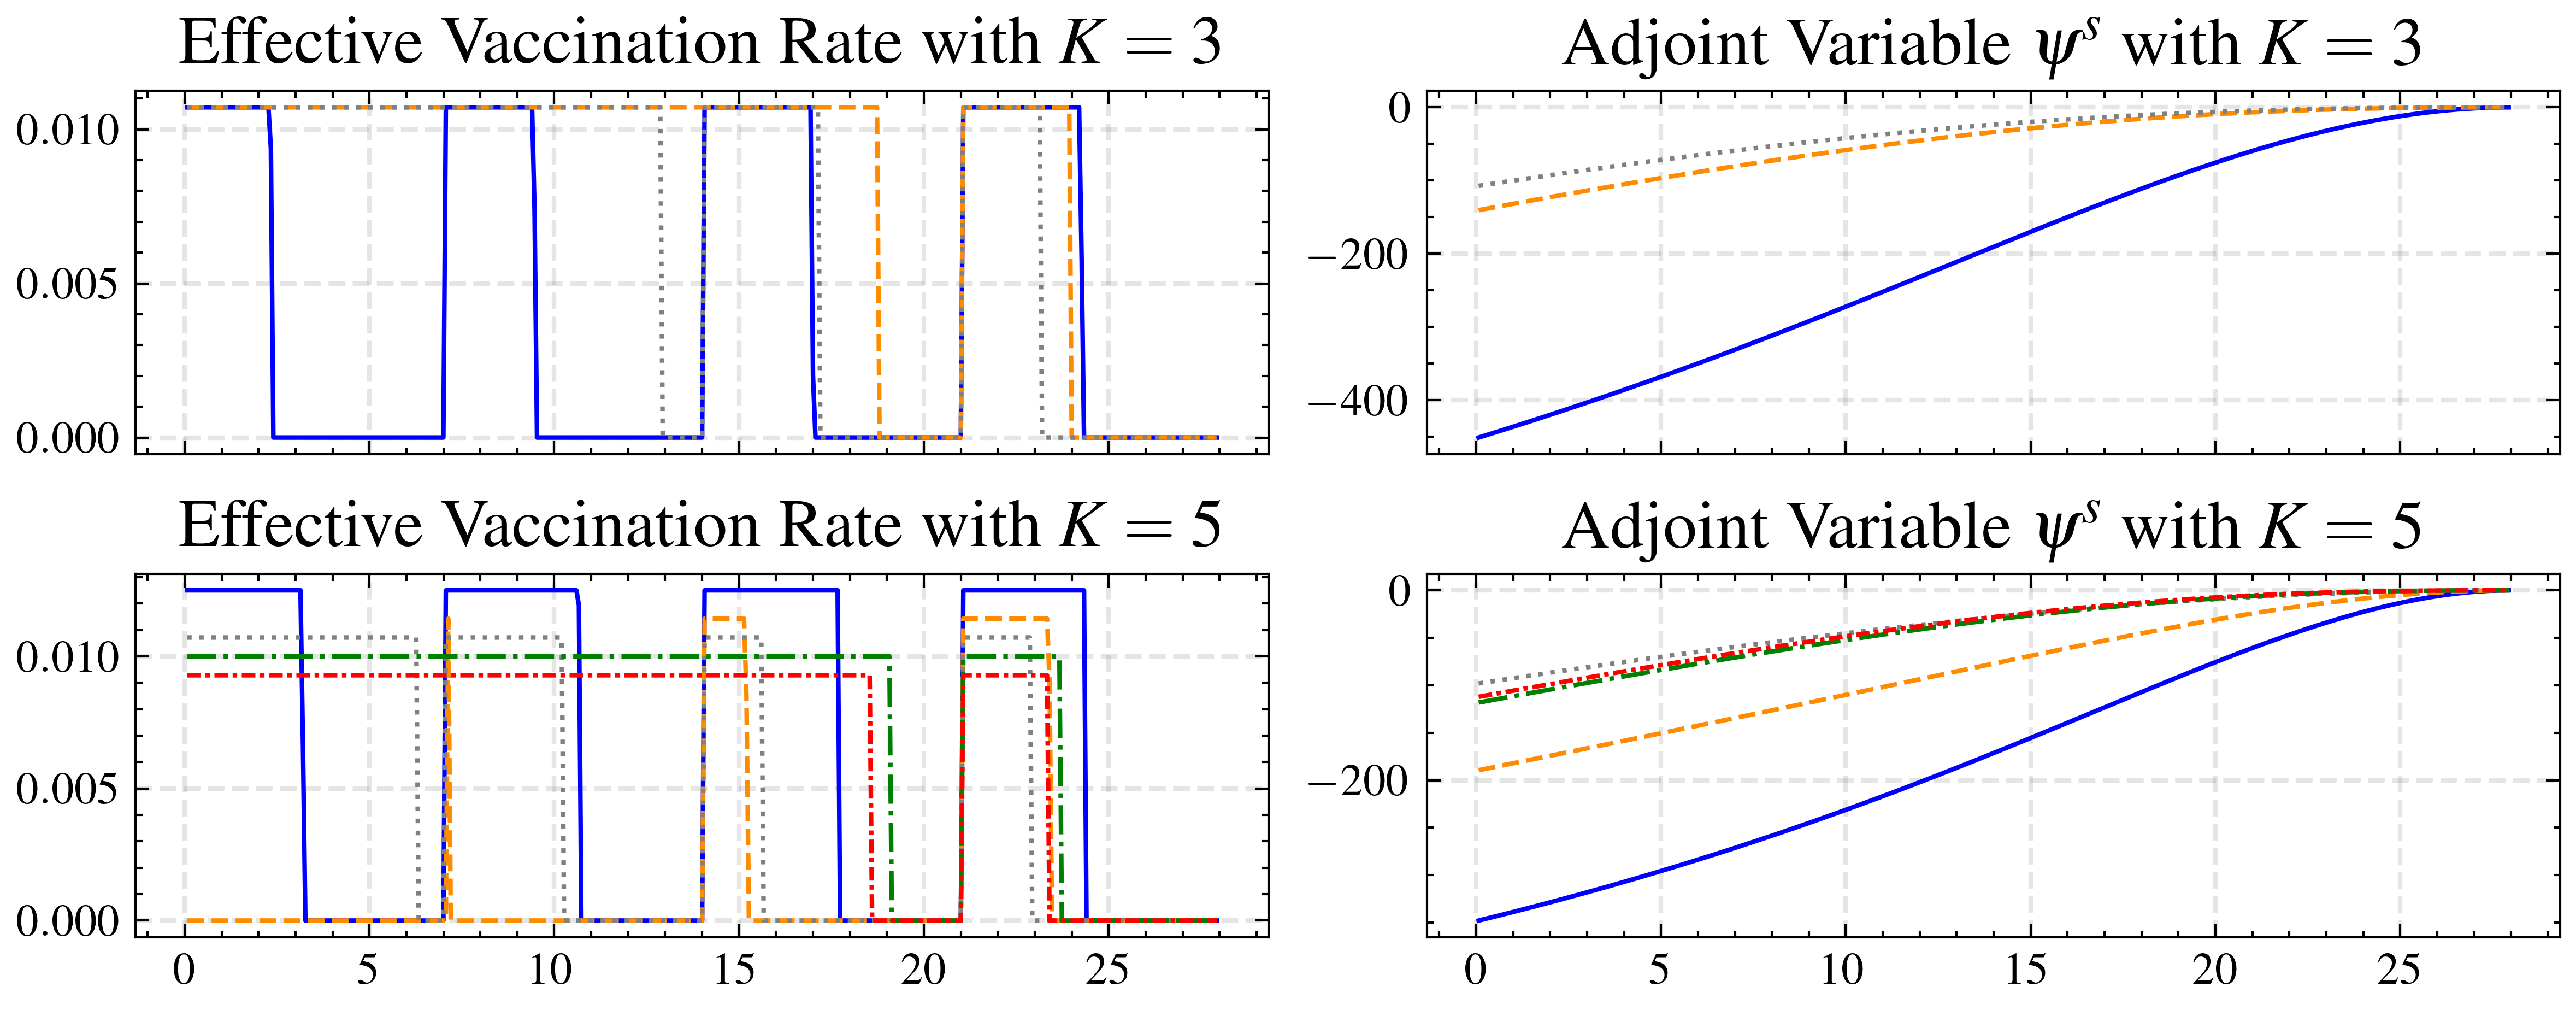

In [23]:
T = 28
gamma = 1/7
alpha = 0.64
week_max = np.array([1, 2, 3, 4]) / 30

# --- Experiment 1: 3 cities ---
K1 = 3
beta1 = np.array([0.3, 0.2, 0.1])  # all <= 0.4
populations1 = 1e5 * np.array([100, 10, 10])
populations1 = populations1 / populations1.sum()
p_matrix1 = np.array([[0.9,   0.05, 0.05],
                    [0.45,  0.45, 0.10],
                    [0.45,  0.10, 0.45]])
q3_off = np.array([
[0.0,  0.03, 0.02],
[0.02, 0.0,  0.02],
[0.03, 0.01, 0.0 ]
])
q3 = q3_off.copy()
for j in range(3):
    q3[j, j] = -np.sum(q3_off[:, j])
rate_max1 = np.full(K1, 0.3) / T
s0_1 = np.array([0.96, 0.97, 0.95])
i0_1 = np.array([0.02, 0.02, 0.01])
params1 = {'T': T,
        'populations': populations1,
        'p_matrix': p_matrix1,
        'q_matrix': q3,
        'beta': beta1,
        'alpha': alpha,
        'gamma': gamma,
        'npd': 15,
        'remote': True,
        's0': s0_1,
        'i0': i0_1,
        'cv': 0.01,
        'ch': 100,
        'week_max': week_max,
        'rate_max': rate_max1,
        'RTOL': 1e-6,
        'OTOL': 1e-6}

# --- Experiment 2: 5 cities ---
K2 = 5
beta2 = np.array([0.35, 0.3, 0.25, 0.2, 0.15])
populations2 = 1e5 * np.array([50, 30, 10, 5, 5])
populations2 = populations2 / populations2.sum()
p_matrix2 = np.array([
    [0.8,  0.05, 0.05, 0.05, 0.05],
    [0.1,  0.7,  0.1,  0.05, 0.05],
    [0.05, 0.1,  0.7,  0.1,  0.05],
    [0.05, 0.05, 0.1,  0.7,  0.1],
    [0.05, 0.05, 0.05, 0.1,  0.75]
])
q5_off = np.array([
    [0.0,  0.02, 0.01, 0.03, 0.02],
    [0.01, 0.0,  0.02, 0.01, 0.03],
    [0.02, 0.01, 0.0,  0.02, 0.01],
    [0.01, 0.03, 0.01, 0.0,  0.02],
    [0.03, 0.01, 0.02, 0.01, 0.0 ]
])
q5 = q5_off.copy()
for j in range(5):
    q5[j, j] = -np.sum(q5_off[:, j])
rate_max2 = np.array([0.35, 0.32, 0.3, 0.28, 0.26]) / T
s0_2 = np.full(K2, 0.97)  # > 0.95 for all cities
i0_2 = np.full(K2, 0.01)
params2 = {'T': T,
        'populations': populations2,
        'p_matrix': p_matrix2,
        'q_matrix': q5,
        'beta': beta2,
        'alpha': alpha,
        'gamma': gamma,
        'npd': 15,
        'remote': True,
        's0': s0_2,
        'i0': i0_2,
        'cv': 0.01,
        'ch': 100,
        'week_max': week_max,
        'rate_max': rate_max2,
        'RTOL': 1e-6,
        'OTOL': 1e-6}

experiments = [params1, params2]

with open("simulation_results2.pkl", "rb") as f:
    results = pickle.load(f)

fig, ax = plt.subplots(2, 2, figsize=(8, 3.5), sharex=True)
colors = ['blue', 'darkorange', 'gray', 'green', 'red', 'purple', 'brown', 'olive']
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1)), (0, (1, 1)), (0, (5, 5)), (0, (3, 5, 1, 5))]

for exp_idx, (params, (m, w, psi_s)) in enumerate(zip(experiments, results)):
    K = len(params['populations'])
    for city in range(K):
        # Column 1: effective vaccination rate w[city][1:-1]
        ax[exp_idx, 0].plot(m.time[1:-1], w[city][1:-1],
                            label=f'City {city+1}',
                            color=colors[city % len(colors)],
                            linestyle=linestyles[city % len(linestyles)])
        # Column 2: adjoint variable psi_s[city][1:-1]
        ax[exp_idx, 1].plot(m.time[1:-1], psi_s[city][1:-1],
                            label=f'City {city+1}',
                            color=colors[city % len(colors)],
                            linestyle=linestyles[city % len(linestyles)])
    ax[exp_idx, 0].set_title(r'Effective Vaccination Rate with $K={}$'.format(K), fontsize=15)
    ax[exp_idx, 1].set_title(f'Adjoint Variable $\psi^s$ with  $K={K}$', fontsize=15)
    ax[exp_idx, 0].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2)
    ax[exp_idx, 1].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2)
    if exp_idx == 2:
        ax[exp_idx, 0].set_xlabel('Time (Days)', fontsize=12)
        ax[exp_idx, 1].set_xlabel('Time (Days)', fontsize=12)
    ax[exp_idx, 0].tick_params(axis='both', labelsize=10)
    ax[exp_idx, 1].tick_params(axis='both', labelsize=10)

# Create a global legend (based on the maximum number of cities among experiments)
max_K = max(len(params['populations']) for params in experiments)
legend_lines = [plt.Line2D([0], [0], color=colors[i], linestyle=linestyles[i], linewidth=2)
                for i in range(max_K)]
legend_labels = [f'City {i+1}' for i in range(max_K)]
#fig.legend(legend_lines, legend_labels, loc='lower center', fontsize=12,
#           ncol=max_K, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../images_paper/figure2.pdf")
plt.show()